## social Group Optimization

In [1]:
import numpy as np; 
import random as rd;
import operator; 
import pandas as pd; 
from matplotlib import pyplot as plt; 
import random as rd;
import collections;
from itertools import permutations;

In [2]:
class Graph():
    """
    Graph: class creates distance matrix for TSP problem. 
    """
    size= 0; 
    def __init__(self, rank: int, matrix: list = None):
        """
            :param rank: rank of the cost matrix 
        """
        self.rank = rank
        if matrix is not None: 
            self.matrix = np.asarray(matrix);
            self.__adjust()
        
    
    def __adjust(self):
        self.matrix = np.c_[np.zeros(self.rank), self.matrix]
        self.matrix = np.r_[np.zeros((1, self.rank+1)), self.matrix]
        
        
    def auto_create(self): 
        """
            Auto_create(self): creates random test distance matrix on its own. 
        """
        G= np.zeros((self.rank, self.rank))
        for i in range(self.rank):
            for j in range(self.rank):
                if i==j :
                    continue;
                
                elif(G[i][j]==0):
                    G[i][j]= rd.randint(1, self.rank)
                    G[j][i]= G[i][j]
                else: 
                    continue;
                
        self.matrix = G
        #print(G)
        self.__adjust()
        return self.matrix
    
    def create(self):
        """
            Create(self): users can create their own customized distance matrix. 
        """
        G= np.zeros((self.rank, self.rank))
        for i in range(self.rank):
            for j in range(self.rank):
                if i==j:
                    continue; 
                    
                elif(G[i][j]==0): 
                    G[j][i] = G[i][j] = int(input(f"cost from city{i} to city{j} "))
                else: 
                    continue; 
        
        self.matrix = G
        self.__adjust()
        return self.matrix

In [3]:
class Person(): 
    def __init__(self, rank: int):
        self.rank = rank; 
        self.trait = np.zeros((rank), dtype='int')
        for i in range(rank):
            rand = rd.randint(1, rank)
            
            while (rand in self.trait):
                rand = rd.randint(1, rank)
            self.trait[i] = rand;     
    def __str__(self):
        return f"person.trait =  is {str(self.trait)} "

In [5]:
class Fitness():
    """
     It is to calculate the fitness of route based on the distance matrix. 
    """
    def __init__(self, graph: Graph, route = None):
        """
        Fiteness(self, route= list or rank 0 matrix, graph= adjacency_matrix): creates 
        the object of Fitness class which calculates the routeCost and fitness attached. 
        """
        #self.route= person.trait; 
        self.cost= 0.0; 
        self.fitness=0.0;
        self.costmatrix= graph.matrix;
        self.graph= graph
        #print(self.graph)
        self.route= route
        
        
    def routeCost(self, person: Person = None):
        """
        RouteCost(self): calculates cost related to particular route.
        """
        if person is not None:
            route= person.trait
        else: 
            route = self.route
            
        assert len(route) == self.graph.rank , "rank mismatch"

        
        pathdistance= 0; 
        #print(f"route = {route}, routelen= {len(route)}")
        routelen = len(route)
        for i in range(routelen):
            fromCity= route[i]
            toCity= None
            if i+1<len(route):
                toCity= route[i+1]
            else:
                toCity= route[0]

            pathdistance+= self.costmatrix[fromCity][toCity]

        self.cost= pathdistance
        
        return self.cost
    


In [66]:
class Operators: 
    graph = np.zeros((1, 1)); 
    __totalDist= 0; 
    def __init__(self, graph= None):
        
        """
        Operators(self, graph): It takes graph or distance matrix as its first argument and perform\
        perform various Operations over the routes required for TSP. 
        """
        if graph is not None:
            self.graph= graph   
        print(graph)
        
    
    def __totaldistance(self, route):
        td= 0.0
        costmatrix= self.graph.matrix
        routelen= len(route)
        assert routelen == self.graph.rank, "rank mismatch"
        
        
        for i in range(routelen-1):
            td+= costmatrix[route[i]][route[i+1]]
            
        td+= costmatrix[route[-1]][route[0]]
        
        return td
            
    
    def crossOver(self, route1, route2, C: float):
        """
            CrossOver(self, route1, route2, c1, r1): 
                it takes two routes as its first two argument and c1 , r1 as parameter to decide crossover length.
        """
        clen = int((C*len(route1) * np.random.random()))
        res = np.zeros((len(route1)), dtype = np.int)
        k= rd.randint(0, len(route1)-1)
        '''
        if np.random.random() > 0.5:
            k= rd.randint(0, len(route1)-1)  
            
        else:
            k= self.__injectionPoint(route1); 
        #k=3
        '''
        i=k
        j=0
        for _ in range(clen):
            if i == (len(route2)-1):
                i=0
            res[j] = route2[i]
            j+=1
            i+=1
        l=0    
        while j<len(route2):
            if route1[l] not in res:
                res[j] = route1[l]
                j+=1
            
            l+=1
            
        return res    
    
    
    def __injectionPoint(self, route):
        """
            InjectionPoint(self, route): it takes route as its first and only argument. 
                Returns index position as where the injection needs to be done on the basis of distance between two cities. 
                
        """
        totalDist = self.__totaldistance(route); 
        costmatrix= self.graph
        
        dmax= costmatrix[route[0]][route[1]]/totalDist
        injPnt= 0
        for i in range(1, len(route)-1):
            d= costmatrix[route[i]][route[i+1]]/totalDist
            if d>dmax:
                injPnt = i
                dmax = d
                
        return i
    
    def inject(self, route, hfactor= 0.3):
        """
        Inject(self, route, hfactor = 0.3): 
            it takes route as its first argument and hfactor which has default value of 0.3. 
            It injects set of city called vc into the current particle bringing the change in the particle.
        """
      
        hfaclen= int(hfactor*len(route));
        perm= np.random.permutation(route);
        vc= perm[:hfaclen]

        
        inPoint= self.__injectionPoint(route); 
        newroute= np.zeros((route.shape), dtype = np.int); 
        i= inPoint

        for j in range(hfaclen):
            if i== len(route):
                i=0; 
            newroute[i]= vc[j]
            i+=1

        routeLen= len(route); 
        j=i=0; 
        while i< routeLen:
            if route[i] not in newroute:
                while newroute[j] != 0 and j<routeLen:
                    j+=1
                newroute[j]= route[i]
                i+=1
            else: 
                i+=1; 
            
        print(f"newroute processed under inject: {newroute}")        
        return newroute
        
    def reverse(self, route, s, e): 
        """
         Reverse(self, route, s, e): It does sectional reversal over the route as 1st argument, 
         start point as second and end point as last and third argument. 
        """
        newroute= route
        if s==1: 
            newroute[s-1:e] = route[e-1::-1]
        else:
            newroute[s-1:e] = route[e-1:s-2:-1]
        print(f"newroute processed under reverse: {newroute}")
        return newroute


In [67]:
class SGO():
    def __init__(self, graph: Graph, person_count: int,  generations: int, C: float = 0.4, target: int= None):
        self.graph = graph
        self.person_count = person_count
        self.generations = generations
        self.social_group = [Person(self.graph.rank) for i in range(person_count)]
        self.sgbest_trait = []; 
        self.sgbest_value = float('inf')
        self.fitness= Fitness(self.graph)
        self.Opr= Operators(self.graph)
        self.C = C
        self.target = target
    
    def printgroup(self):
        for person in self.social_group:
            print(f"{person}, fitness= {self.fitness.routeCost(person)}")
            
    def setgbest(self):
        for person in self.social_group:
            person_fitness = self.fitness.routeCost(person)
            if person_fitness < self.sgbest_value: 
                self.sgbest_value = person_fitness
                self.sgbest_trait = person.trait
                
    def improve_group(self):
        c= self.C
        for i in range(len(self.social_group)):
            person= self.social_group[i]
            old_fitness = self.fitness.routeCost(person)
            r2= self.sgbest_trait;
            r1= person.trait;
            res = self.Opr.crossOver(route1 = r1, route2 = r2, C=c)
            new_fitness = Fitness(self.graph, res).routeCost()
            if new_fitness < old_fitness: 
                self.social_group[i].trait = res
    
    def acquire(self):
        for i in range(len(self.social_group)):
            res= None
            i_r= rd.randint(0, len(self.social_group)-1)
            pi = self.social_group[i]
            
            while i == i_r:
                i_r = rd.randint(0, len(self.social_group) -1) 
                
            Xr= self.social_group[i_r]
            
            fitness_Xr= self.fitness.routeCost(Xr)
            fitness_pi= self.fitness.routeCost(pi)
            
            if fitness_pi < fitness_Xr: 
                res= self.Opr.crossOver(route1= Xr.trait, route2= pi.trait, C= rd.random())
            else: 
                res= self.Opr.crossOver(route1= pi.trait, route2= Xr.trait, C= rd.random())
            
            res= self.Opr.crossOver(route1=res, route2=self.sgbest_trait, C= rd.random())
            
            new_fitness = Fitness(self.graph, res).routeCost()
            
            if new_fitness < fitness_pi:
                self.social_group[i].trait = res
    
    def solve(self):
        iterations = []
        costs = []
        for i in range(self.generations):
            self.setgbest()
            self.improve_group()
            self.setgbest()
            self.acquire()
            print(f"<<<===============================================================>>>")
            print(f"generation= {i}, gbestroute= {self.sgbest_trait}, gbest_value= {self.sgbest_value}")

            if self.target != None: 
                if self.sgbest_value <= self.target: 
                    break
            costs.append(self.sgbest_value)
            iterations.append(i); 
        
        self.setgbest()
        
        return self.sgbest_trait, self.sgbest_value, iterations, costs
                
                
        

In [68]:
graph= auto
sgo= SGO(graph, person_count = 5, generations = 2, C=0.5)
sgo.printgroup()
sgo.setgbest()
print(f"sgo.sgbest_trait= {sgo.sgbest_trait}, sgo.sgbest_value= {sgo.sgbest_value}")
sgo.improve_group()
print("<<<=========================after improve=========================>>>")
sgo.printgroup()
print("<<<==========================after acquire====================>>>")
sgo.acquire()
sgo.printgroup()

person.trait =  is [2 6 3 4 5 1] , fitness= 28.0
person.trait =  is [6 1 3 4 2 5] , fitness= 21.0
person.trait =  is [2 3 6 5 4 1] , fitness= 23.0
person.trait =  is [6 5 4 1 3 2] , fitness= 18.0
person.trait =  is [2 4 3 5 1 6] , fitness= 24.0
sgo.sgbest_trait= [6 5 4 1 3 2], sgo.sgbest_value= 18.0
<<<=========================after improve=========================>>>
person.trait =  is [5 4 2 6 3 1] , fitness= 21.0
person.trait =  is [6 1 3 4 2 5] , fitness= 21.0
person.trait =  is [2 3 6 5 4 1] , fitness= 23.0
person.trait =  is [6 5 4 1 3 2] , fitness= 18.0
person.trait =  is [2 4 3 5 1 6] , fitness= 24.0
<<<==========================after acquire====================>>>
person.trait =  is [5 4 2 6 3 1] , fitness= 21.0
person.trait =  is [6 1 3 4 2 5] , fitness= 21.0
person.trait =  is [2 3 6 5 4 1] , fitness= 23.0
person.trait =  is [6 5 4 1 3 2] , fitness= 18.0
person.trait =  is [2 4 3 5 1 6] , fitness= 24.0


In [70]:
#    def __init__(self, graph: Graph, person_count: int,  generations: int, C: float = 0.4):
graph= [[0, 29, 20, 21, 16, 31, 100, 12, 4, 31, 18],\
                [29, 0, 15, 29, 28, 40, 72, 21, 29, 41, 12],\
                [20, 15, 0, 15, 14, 25, 81, 9, 23, 27, 13],\
                [21, 29, 15, 0, 4, 12, 92, 12, 25, 13, 25],\
                [16, 28, 14, 4, 0, 16, 94, 9, 20, 16, 22],\
                [31, 40, 25, 12, 16, 0, 95, 24, 36, 3, 37],\
                [100, 72, 81, 92, 94, 95, 0, 90, 101, 99, 84],\
                [12, 21, 9, 12, 9, 24, 90, 0, 15, 25, 13],\
                [4, 29, 23, 25, 20, 36, 101, 15, 0, 35, 18],\
                [31, 41, 27, 13, 16, 3, 99, 25, 35, 0 ,38],\
                [18, 12, 13, 25, 22, 37, 84, 13, 18, 38, 0]]


costGraph= Graph(rank= 11, matrix= graph)
sgo = SGO(graph= costGraph, person_count = 50, generations = 100, C=0.4, target= 253 )
path, cost, iterations, costs = sgo.solve()
print(f"best path = {path} with cost = {cost}")

<<<===============================================================>>>
generation= 0, gbestroute= [ 6  4  3 11  1  8  5  9  2  7 10], gbest_value= 302.0
<<<===============================================================>>>
generation= 1, gbestroute= [ 7  6 10  4  3 11  9  8  5  1  2], gbest_value= 298.0
<<<===============================================================>>>
generation= 2, gbestroute= [ 6 10  4  5  3 11  7  2  8  9  1], gbest_value= 274.0
<<<===============================================================>>>
generation= 3, gbestroute= [10  6  4  5  3 11  7  2  8  9  1], gbest_value= 273.0
<<<===============================================================>>>
generation= 4, gbestroute= [10  6  4  3 11  7  2  8  9  1  5], gbest_value= 271.0
<<<===============================================================>>>
generation= 5, gbestroute= [10  6  4  3 11  7  2  8  9  1  5], gbest_value= 271.0
<<<===============================================================>>>
generation= 6, gbe

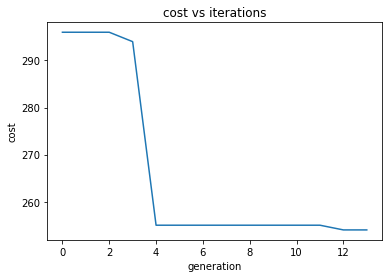

best route= [ 5  8  1  9 11  2  7  3  6 10  4] and best value = 253.0        iteration= 13


In [45]:
Xsgo = np.asarray(iterations)
Ysgo = np.asarray(costs)

plt.plot(Xsgo,Ysgo)
plt.xlabel('generation')
plt.ylabel('cost')
plt.title('cost vs iterations')
plt.show()

    
print(f"best route= {path} and best value = {cost}\
        iteration= {iterations[-1]}")

In [46]:
def createCostMatrix( mat, rank :int):
    arr= mat.split(); 
    arr= np.asarray((arr), dtype= np.int)
    arr= np.reshape(arr, (rank, rank))
    return arr

In [47]:
#benchmark matrix for tsp with target 937

a= """
   0  83  93 129 133 139 151 169 135 114 110  98  99  95  81 152 159 181 172 185 147 157 185 220 127 181
  83   0  40  53  62  64  91 116  93  84  95  98  89  68  67 127 156 175 152 165 160 180 223 268 179 197
  93  40   0  42  42  49  59  81  54  44  58  64  54  31  36  86 117 135 112 125 124 147 193 241 157 161
 129  53  42   0  11  11  46  72  65  70  88 100  89  66  76 102 142 156 127 139 155 180 228 278 197 190
 133  62  42  11   0   9  35  61  55  62  82  95  84  62  74  93 133 146 117 128 148 173 222 272 194 182
 139  64  49  11   9   0  39  65  63  71  90 103  92  71  82 100 141 153 124 135 156 181 230 280 202 190
 151  91  59  46  35  39   0  26  34  52  71  88  77  63  78  66 110 119  88  98 130 156 206 257 188 160
 169 116  81  72  61  65  26   0  37  59  75  92  83  76  91  54  98 103  70  78 122 148 198 250 188 148
 135  93  54  65  55  63  34  37   0  22  39  56  47  40  55  37  78  91  62  74  96 122 172 223 155 128
 114  84  44  70  62  71  52  59  22   0  20  36  26  20  34  43  74  91  68  82  86 111 160 210 136 121
 110  95  58  88  82  90  71  75  39  20   0  18  11  27  32  42  61  80  64  77  68  92 140 190 116 103
  98  98  64 100  95 103  88  92  56  36  18   0  11  34  31  56  63  85  75  87  62  83 129 178 100  99
  99  89  54  89  84  92  77  83  47  26  11  11   0  23  24  53  68  89  74  87  71  93 140 189 111 107
  95  68  31  66  62  71  63  76  40  20  27  34  23   0  15  62  87 106  87 100  93 116 163 212 132 130
  81  67  36  76  74  82  78  91  55  34  32  31  24  15   0  73  92 112  96 109  93 113 158 205 122 130
 152 127  86 102  93 100  66  54  37  43  42  56  53  62  73   0  44  54  26  39  68  94 144 196 139  95
 159 156 117 142 133 141 110  98  78  74  61  63  68  87  92  44   0  22  34  38  30  53 102 154 109  51
 181 175 135 156 146 153 119 103  91  91  80  85  89 106 112  54  22   0  33  29  46  64 107 157 125  51
 172 152 112 127 117 124  88  70  62  68  64  75  74  87  96  26  34  33   0  13  63  87 135 186 141  81
 185 165 125 139 128 135  98  78  74  82  77  87  87 100 109  39  38  29  13   0  68  90 136 186 148  79
 147 160 124 155 148 156 130 122  96  86  68  62  71  93  93  68  30  46  63  68   0  26  77 128  80  37
 157 180 147 180 173 181 156 148 122 111  92  83  93 116 113  94  53  64  87  90  26   0  50 102  65  27
 185 223 193 228 222 230 206 198 172 160 140 129 140 163 158 144 102 107 135 136  77  50   0  51  64  58
 220 268 241 278 272 280 257 250 223 210 190 178 189 212 205 196 154 157 186 186 128 102  51   0  93 107
 127 179 157 197 194 202 188 188 155 136 116 100 111 132 122 139 109 125 141 148  80  65  64  93   0  90
 181 197 161 190 182 190 160 148 128 121 103  99 107 130 130  95  51  51  81  79  37  27  58 107  90   0
 
"""

In [55]:
graph = createCostMatrix(mat= a, rank= 26)
costGraph= Graph(rank= 26, matrix= graph)
sgo = SGO(graph= costGraph, person_count = 250, generations = 500, C=0.5, target= 937 )
path, cost, iterations, costs = sgo.solve()
print(f"best path = {path} with cost = {cost}")

<<<===============================================================>>>
generation= 0, gbestroute= [25 21 10 12  8 15 17 22 20 26 23 24 13  2 14  6  7 16 19 18 11  3  5  9  1
  4], gbest_value= 2085.0
<<<===============================================================>>>
generation= 1, gbestroute= [20 18 24 23 25 12 11  4  2  5  9  6  7  1 17 26 19 16 14 21 22 15  3  8 10
 13], gbest_value= 1830.0
<<<===============================================================>>>
generation= 2, gbestroute= [17 26 19 16 13 10  3 14  8 15 21 24 23 25 12 11  4  2  5  9  7  6  1 22 18
 20], gbest_value= 1691.0
<<<===============================================================>>>
generation= 3, gbestroute= [26 23 24 25 22 11 12 21 17 19 16 13 10 14  9  6  7  1 15  3  8 20 18  2  4
  5], gbest_value= 1647.0
<<<===============================================================>>>
generation= 4, gbestroute= [19 16 13 10 14  9  6  7  1 15  3  8 20 18 17 21 22 26 23 24 25  2 12 11  4
  5], gbest_value= 1541.0
<<<==

generation= 43, gbestroute= [10 11 13 12 15  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25  1
 14], gbest_value= 974.0
<<<===============================================================>>>
generation= 44, gbestroute= [10 11 13 12 15  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25  1
 14], gbest_value= 974.0
<<<===============================================================>>>
generation= 45, gbestroute= [10 11 13 12 15  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25  1
 14], gbest_value= 974.0
<<<===============================================================>>>
generation= 46, gbestroute= [10 11 13 12 15  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25  1
 14], gbest_value= 974.0
<<<===============================================================>>>
generation= 47, gbestroute= [10 11 13 12 15  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25  1
 14], gbest_value= 974.0
<<<===============================================================>>>
gener

<<<===============================================================>>>
generation= 89, gbestroute= [13 12 11 16 19 20 18 17 21 22 26 23 24 25  1  3  2  4  6  5  7  8  9 10 14
 15], gbest_value= 958.0
<<<===============================================================>>>
generation= 90, gbestroute= [13 12 11 16 19 20 18 17 21 22 26 23 24 25  1  3  2  4  6  5  7  8  9 10 14
 15], gbest_value= 958.0
<<<===============================================================>>>
generation= 91, gbestroute= [13 12 11 16 19 20 18 17 21 22 26 23 24 25  1  3  2  4  6  5  7  8  9 10 14
 15], gbest_value= 958.0
<<<===============================================================>>>
generation= 92, gbestroute= [13 12 11 16 19 20 18 17 21 22 26 23 24 25  1  3  2  4  6  5  7  8  9 10 14
 15], gbest_value= 958.0
<<<===============================================================>>>
generation= 93, gbestroute= [13 12 11 16 19 20 18 17 21 22 26 23 24 25  1  3  2  4  6  5  7  8  9 10 14
 15], gbest_value= 958.0
<<<==

generation= 174, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 175, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 176, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 177, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 178, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>


  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 218, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 219, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 220, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 221, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 222, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25


<<<===============================================================>>>
generation= 260, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 261, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 262, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 263, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 264, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0


<<<===============================================================>>>
generation= 345, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 346, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 347, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 348, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 349, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0


  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 388, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 389, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 390, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 391, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 392, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25


<<<===============================================================>>>
generation= 432, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 433, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 434, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 435, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 436, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0


generation= 475, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 476, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 477, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 478, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>
generation= 479, gbestroute= [15 13 12 11 10 14  3  2  4  6  5  7  8  9 16 19 20 18 17 21 22 26 23 24 25
  1], gbest_value= 955.0
<<<===============================================================>>>


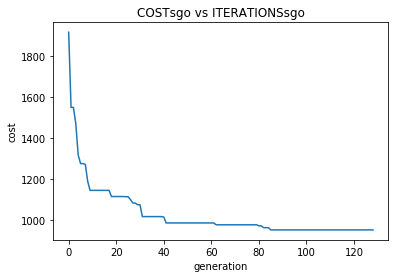

best route= [17 18 20 19 16 11 12 13 15 14 10  9  8  7  5  6  4  3  2  1 25 24 23 26 22
 21] and best value = 937.0        iteration= 128


In [19]:
Xsgo = np.asarray(iterations)
Ysgo = np.asarray(costs)

plt.plot(Xsgo,Ysgo)
plt.xlabel('generation')
plt.ylabel('cost')
plt.title('COSTsgo vs ITERATIONSsgo')
plt.show()

    
print(f"best route= {path} and best value = {cost}\
        iteration= {iterations[-1]}")

In [14]:
graph = createCostMatrix(mat= a, rank= 26)
costGraph= Graph(rank= 26, matrix= graph)
sgo = SGO(graph= costGraph, person_count = 250, generations = 500, C=0.5, target= 937 )
path, cost, iterations, costs = sgo.solve()
print(f"best path = {path} with cost = {cost}")

<<<===============================================================>>>
generation= 0, gbestroute= [14 17 16  2  4  5  3  7 21 20 13 15  9  8 22 18  6  1 25 23 24 26 19 11 10
 12], gbest_value= 1912.0
<<<===============================================================>>>
generation= 1, gbestroute= [17 16  2  4  5  3  7  8 21 19 20 13 10  9 12  6  1 25 23 24 26 11 14 15 22
 18], gbest_value= 1686.0
<<<===============================================================>>>
generation= 2, gbestroute= [17 16  9  6  1 25 23 24 26 11 14 15  2  4  5  3  7  8 10 19 13 21 12 22 18
 20], gbest_value= 1583.0
<<<===============================================================>>>
generation= 3, gbestroute= [ 9 16 19 20 17 21  6  1  2  4  5  3 25 23 24 26 22 18 13 12 11 15 14 10  7
  8], gbest_value= 1398.0
<<<===============================================================>>>
generation= 4, gbestroute= [ 9 16 19 20 17 21  6  1  2  4  5  3 25 23 24 26 22 18 13 12 11 15 14 10  7
  8], gbest_value= 1398.0
<<<==

<<<===============================================================>>>
generation= 43, gbestroute= [17 21 22 25 23 24 26 11 10 14 15 13 12  1  3  2  6  4  5  7  8  9 16 19 20
 18], gbest_value= 1078.0
<<<===============================================================>>>
generation= 44, gbestroute= [17 21 22 25 23 24 26 11 10 14 15 13 12  1  3  2  6  4  5  7  8  9 16 19 20
 18], gbest_value= 1078.0
<<<===============================================================>>>
generation= 45, gbestroute= [17 21 22 25 23 24 26 11 10 14 15 13 12  1  3  2  6  4  5  7  8  9 16 19 20
 18], gbest_value= 1078.0
<<<===============================================================>>>
generation= 46, gbestroute= [17 21 22 25 23 24 26 11 10 14 15 13 12  1  3  2  6  4  5  7  8  9 16 19 20
 18], gbest_value= 1078.0
<<<===============================================================>>>
generation= 47, gbestroute= [17 21 22 25 23 24 26 11 10 14 15 13 12  1  3  2  6  4  5  7  8  9 16 19 20
 18], gbest_value= 1078.0


<<<===============================================================>>>
generation= 85, gbestroute= [12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18 17 21 22 25 23 24
 26], gbest_value= 1010.0
<<<===============================================================>>>
generation= 86, gbestroute= [12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18 17 21 22 25 23 24
 26], gbest_value= 1010.0
<<<===============================================================>>>
generation= 87, gbestroute= [12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18 17 21 22 25 23 24
 26], gbest_value= 1010.0
<<<===============================================================>>>
generation= 88, gbestroute= [12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18 17 21 22 25 23 24
 26], gbest_value= 1010.0
<<<===============================================================>>>
generation= 89, gbestroute= [12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18 17 22 25 23 24 26
 21], gbest_value= 1007.0


<<<===============================================================>>>
generation= 169, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 170, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 171, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 172, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 173, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0


<<<===============================================================>>>
generation= 210, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 211, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 212, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 213, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 214, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0


<<<===============================================================>>>
generation= 253, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 254, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 255, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 256, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 257, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0


<<<===============================================================>>>
generation= 340, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 341, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 342, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 343, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
<<<===============================================================>>>
generation= 344, gbestroute= [22 25 24 23 26 21 12 13 11 10 14 15  1  2  3  4  6  5  7  8  9 16 19 20 18
 17], gbest_value= 987.0
